<p></p>

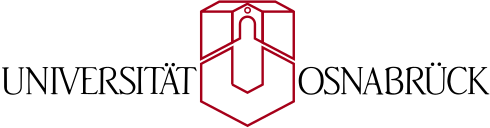
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Disclaimer

Die hier enthaltenen Lösungen stellen nur Beispiele dar. Sie erheben keinerlei Anspruch auf Richtig- und Vollständigkeit und sind **nicht** zur Vorbereitung für die Klausur geeignet! 

Jegliche Vervielfältigung und Verbreitung über die Veranstaltung "Künstliche Intelligenz" im Wintersemester 2020/21 der Universität Osnabrück hinaus ist nicht gestattet.

# Übungsblatt 10: Reinforcement-Learning

## Aufgabe: Blackjack mit Q-Learning


In der Vorlesung haben Sie *Q-Learning* als einfaches Reinforcement-Learning-Verfahren kennengelernt.
In dieser Aufgabe werden Sie diesen Algorithmus verwenden, um eine Policy für das Spiel *Blackjack* zu lernen.

Die Implementation der Spiellogik wird erneut durch das `gym`-Paket bereitgestellt, welches Sie schon vom vorherigen Blatt kennen. Dieses implementiert die Domäne [`Blackjack-v0`](https://gym.openai.com/envs/Blackjack-v0/), welche ein vereinfachtes Blackjack-Spiel simuliert.

Beim Blackjack besteht das Spielziel darin, mit 2 oder mehr Karten möglichst nahe an den Wert 21 zu gelangen, ohne diesen zu überschreiten. Dabei wird gegen den Kartengeber (*Dealer*) gespielt. Initial gibt der *Dealer* zwei offene Karten an den Spieler sowie eine offene und eine verdeckte Karte an sich selbst. Anschließend kann der Spieler nach Wunsch weitere Karten vom *Dealer* anfordern (*Hit*), bis der Kartenwert über 21 ist (*Bust*) oder der Spieler keine weiteren Karten mehr möchte (*Stick*). Ist kein *Bust* aufgetreten, so ist danach der *Dealer* an der Reihe. Dieser zieht so lange weitere Karten, bis der Kartenwert über 17 oder er selbst *Bust* ist.

In dieser vereinfachten Spiellogik stehen dem Spieler daher nur 2 mögliche Aktionen zur Verfügung:

- *Stick* (0): Es werden keine weiteren Karten gezogen und das Spielergebnis wird ausgewertet. Der *Reward* ist entweder $+1$ bei Gewinn, $-1$ bei Verlust oder $0$ bei Gleichstand. 
- *Hit* (1): Es wird eine weitere Karte gezogen. Der *Reward* ist hier entweder $-1$ bei einem *Bust* oder $0$.

Die Karten besitzen die folgenden Wertigkeiten:

- Das Ass zählt 1 oder 11 Punkte (immer sinnvollster Wert)
- 2-10 zählen entsprechend ihrer Nummer
- Bildkarten zählen 10 Punkte

Der Spielzustand wird in der `Blackjack`-Domäne durch ein 3-Tupel repräsentiert: 
1. Kartenwert des Spielers
2. Sichtbare Karte des *Dealers* (1-10, wobei 1 das Ass ist)
3. "Nutzbares" Ass, welches als 11 Punkte gezählt werden kann, ohne *Bust* zu werden (0 oder 1)

### 
Implementieren Sie einen Agenten für das Blackjack-Spiel, indem Sie die Methoden

- `update_Q`
- `choose_action`
- `learn_Q`

auf Basis des Q-Learning-Algorithmus aus der Vorlesung vervollständigen. In `choose_action` sollen Sie dabei eine `epsilon-greedy`-Strategie implementieren. Das bedeutet, dass Sie abhängig von einem *epsilon* entweder eine zufällige Aktion ausführen (*Exploration*), oder die beste verfügbare (maximaler Q-Wert, *Exploitation*). Dieses *epsilon* nimmt während des Trainingsprozesses kontinuierlich ab.

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from collections import deque, defaultdict
import sys

def plot_policy(policy):
    """
    Plots the policy
    """

    usable_ace_img = -np.ones((21+1, 11+1 ))
    nonusable_ace_img = -np.ones((21+1, 11+1))

    for key,val in policy.items():
        players_sum = key[0]
        dealers_card = key[1]

        if players_sum > 21:
            continue

        if key[2]:
            # usable ace
            usable_ace_img[players_sum, dealers_card] = val
        else:
            # nonusable ace
            nonusable_ace_img[players_sum, dealers_card] = val

    # fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle('Blackjack policy')
    fig.subplots_adjust(top=0.8)
    # fig.gca().invert_yaxis()

    ax1.imshow(usable_ace_img)
    ax1.set_title('usable ace')
    ax1.set_ylabel('player sum')
    ax1.set_xlabel('dealer card')
    ax1.set_ylim(ax1.get_ylim()[::-1])

    ax2.imshow(nonusable_ace_img)
    ax2.set_title('unusable ace')
    ax2.set_ylabel('player sum')
    ax2.set_xlabel('dealer card')
    ax2.set_ylim(ax2.get_ylim()[::-1])

    plt.show()

In [ ]:
class BlackjackAgent:
    """
    Agent to play blackjack on the openai gym Environment
    """
    def __init__(self, env):
        """
        Constructs the agent.

        param env: the openai environment
        """
        self.env = env
        self.nA = env.action_space.n

        # the q values. access with self.Q[state][action]
        self.Q = defaultdict(lambda: np.zeros(self.nA))

        # the number of times a specific action has been called in this state
        self.k = defaultdict(lambda: np.ones(self.nA))

    
    def get_policy_for_observation(self, Q_s, epsilon):
        """ 
        Calculates the action probabilities corresponding to epsilon-greedy policy 
        """
        policy_s = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / self.nA)
        return policy_s
    

    def choose_action(self, state, epsilon):
        """ 
        Chooses an action in the current state.
        If the state has been visited already (in self.Q dict), choose a random action with probability of episilon, otherwise sample a random action from the action space.

        param state: the current state
        param epsilon: the epsilon value between 0.0 and 1.0
        """
        # TODO implement this!
        
        # Just random sampling
        action = self.env.action_space.sample()
        
        
        if state in self.Q:
            action = np.random.choice(np.arange(self.nA), p=self.get_policy_for_observation(self.Q[state], epsilon))
        else:
            action = self.env.action_space.sample()
        
            
        return action
    
    def update_Q(self, episode, alpha=1.0, gamma=1.0):
        """
        Update the action value function Q using the most recent episode.

        param episode: episode's states, actions and rewards as a list of tuples
            [(state, action, reward), ...]
        param alpha: the learning rate
        param gamma: the discount factor
        """

        states, actions, rewards = zip(*episode)

        # TODO implement this!
        
        
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])

        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]] 
            old_k = self.k[state][actions[i]]

            
            # old_Q plus vector neuen
            # je häufiger ein state, action paar gesehen wurde je kleiner das alpha (alpha /old_k)
            self.Q[state][actions[i]] = old_Q + alpha *(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_k)

            self.k[state][actions[i]] += 1
            
        

    def policy(self):
        """
        Return the optimal policy
        """

        return dict((k,np.argmax(v)) for k, v in self.Q.items())

In [ ]:
def generate_episode(env, agent, epsilon):
    """
    Play a game of blackjack.

    param env: the blackjack environment
    param agent: the agent for the player
    param epsilon: the exploration probability between 0.0 and 1.0
    """

    episode = []
    
    state = env.reset()

    done = False
    while not done:
        action = agent.choose_action(state, epsilon)

        next_state, reward, done, info = env.step(action)

        episode.append((state, action, reward))

        state = next_state

    return episode

def q_learning(env,
               agent,
               n_episodes,
               alpha=1.0, 
               gamma=1.0, 
               epsilon_start=0.9,
               epsilon_decay=None):
    """
    Train the agent using Q-learning.

    param env: the blackjack environment
    param agent: the agent to train
    param n_episodes: the number of episodes for training. This should be sufficiently large (e.g. 1000000)
    param alpha: the learning rate (just 1.0 is usually fine)
    param gamma: the discount factor (1.0 is fine again)
    param epsilon_state: the initial epsilon. This will decay during training
    param epsilon_decay: the decay rate of the epsilon factor. If 'None' this will be set to n_episodes/10
    """
    
    # compute decay factor
    if epsilon_decay is None:
        epsilon_decay = n_episodes / 10

    epsilon = epsilon_start
    
    for i in range(1,n_episodes+1):
        # Some Output
        if i % 1000 == 0:
            print("\rEpisode {}/{} eps {}.".format(i, n_episodes, epsilon), end="")
            sys.stdout.flush()

        # generate episode
        episode = generate_episode(env, agent, epsilon)
        
        # TODO update the agent's Q value from the episode's result
        
        
        agent.update_Q(episode, alpha, gamma)
        
        
        # epsilon decay
        epsilon = 1.0/((i/epsilon_decay) + 1)



    return agent

def evaluate_episodes(env,
                      agent,
                      n_episodes):
    """
    Evaluate the agent over n_episodes
    """

    reward = np.zeros(n_episodes, dtype=np.int8)

    for i in range(n_episodes):
        if i % 1000 == 0:
            print("\rEpisode {}/{}".format(i+1, n_episodes), end="")
            sys.stdout.flush()

        result = generate_episode(env, agent, epsilon=0.0) # epsilon=0 so do not explore at all

        reward[i] = result[-1][2] # store the last reward

    print()
    print("Evaluation:")
    print("Num Won: {}/{}".format(np.count_nonzero(reward > 0), n_episodes))
    print("Num Lost: {}/{}".format(np.count_nonzero(reward < 0), n_episodes))
    print("Num Draw: {}/{}".format(np.count_nonzero(reward == 0), n_episodes))
    print("Total money:", np.sum(reward))

In [ ]:
env = gym.make('Blackjack-v0')
env.natural = True


blackjack_agent = BlackjackAgent(env)

state = env.reset()

# TODO train the agent!


num_training_games = 1000000

blackjack_agent = q_learning(env, blackjack_agent, num_training_games)
policy = blackjack_agent.policy()



evaluate_episodes(env, blackjack_agent, 10000)



### 
Visualisieren Sie den gelernte Policy Ihres Agenten abhängig vom Zustand. Wurde eine valide Strategie gelernt?

In [ ]:


plot_policy(policy)


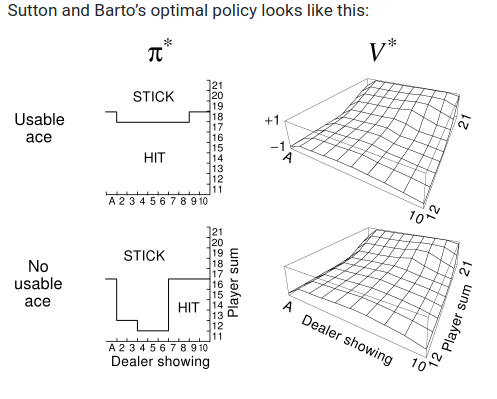


## Aufgabe: Nearest Neighbor Klassifikation

Schreiben Sie ein Programm, das eine *k-Nearest Neighbor Klassifikation* mit "Mehrheitsentscheidung" der $k$ Nachbarn analog zur Vorlesung implementiert. Ähnlichkeitsmaß sei der euklidische Abstand.


### 
Beiliegend finden Sie einen Datensatz `knn_train_data.txt` mit klassifizierten Trainingsdaten und einen Datensatz mit unklassifizierten Testdaten `knn_test_data.txt`. Diese Daten können Sie mittels der bereitgestellten Funktion `load_data` in der folgenden Vorlage laden. Ihre Klassifikationsergebnisse können Sie mit der Funktion `plot_classification` plotten (dabei wird die z-Komponente der Daten automatisch ignoriert). Implementieren Sie nun zunächst das Verfahren für verschiedene $k$ (z.b. 1, 4) mit gleichgewichteter Mehrheitsentscheidung. Testen Sie Ihre Implementation mit dem Testdatensatz.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def load_data():
    """
    Load the dataset from the files 'knn_train_data.txt' and 'knn_test_data.txt' and return it as numpy arrays.
    :return: Tuple with (training samples, test samples, training labels)
    """
    tmp_train = np.loadtxt('knn_train_data.txt') 
    tmp_test = np.loadtxt('knn_test_data.txt')

    return tmp_train[:, :2], tmp_test[:,:2], tmp_train[:,3] # return samples and labels separately

def plot_classification(X, y, alpha=1.0):
    """
    Plots the samples from the dataset (X) with labels (y) as colors. Ignores the z-component.
    :param X: the samples in the shape [n_samples, 3]
    :param y: the samples in the shape [n_samples]
    """
    from matplotlib.colors import ListedColormap
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.scatter(X[:, 0], X[:,1], c=y-1, cmap=cmap_bold,
                edgecolor='k', s=20, alpha=alpha)

def euclidean_distances(samples, x): 
    """
    Calculates the euclidean distance between the samples vector (aka the training data of knn) and one data sample x.
    :param samples: the samples vector in the shape [n_samples, n_features]
    :param x: one sample (shape [n_features])
    """
    return np.sqrt(np.sum((samples-x)**2, axis=1))

In [ ]:
def nearest_neighbors(samples, labels, x, k):
    """
    Find the k nearest neighbors of a data sample x.
    :param samples: sample vector in the shape [n_samples, n_features]
    :param labels: labels in the shape [n_samples]
    :param x: one sample in the shape [n_features]
    :param k: number of nearest neighbors considering for the classification
    :return: class label for x
    """
    
    label = -1
    
    #TODO: 1. Implement k-nearest neighbor
    
    
    
    # TODO: not weighted
    distances = euclidean_distances(samples, x)
    sorted_indices = np.argsort(distances)
    nearest_labels = labels[sorted_indices][:k]

    best = 0
    label = -1
    for y in set(nearest_labels):
        weight = np.sum(np.where(nearest_labels == y))
        
        if weight > best:
            label = y
            best = weight

    
            
    return label

In [ ]:
# TEST CELL
%matplotlib notebook

# load the data
X_train, X_test, y_train = load_data()

# plot the training data
print('Training Data')
plt.figure()
plot_classification(X_train, y_train, alpha=0.2)
plt.show()

#TODO: 2. do k-nearest neighbor classification

#TODO: 3. plot the results with plot_classification



# label test data
y_test = np.zeros(len(X_test))
for n, x in enumerate(X_test):
    y_test[n] = nearest_neighbors(X_train, y_train, x, 4)

# plot test result
print('Test Results')
plt.figure()
plot_classification(X_test, y_test)
plt.show()

# PLOT GRID
nx = 50
ny = 50
x = np.linspace(-1.0, 0.4, nx)
y = np.linspace(-0.3, 0.6, ny)
XY = np.array(np.meshgrid(x,y)).reshape(2, 50*50).T
X_test = XY

y_test = np.zeros(len(X_test))
for n, x in enumerate(X_test):
    y_test[n] = nearest_neighbors(X_train, y_train, x, 4)

# plot test result
print('Test Results')
plt.figure()
plot_classification(X_test, y_test)
plt.show()



### 
Implementieren Sie das Vorgehen, die Mehrheitsmeinung mit dem euklidischen Abstand zu gewichten:

\begin{align}
  d_{E} \left( s, x \right) &= \sqrt{\sum_{i=1}^{n} \left(s_{i} - x_{i}\right)^2} \\
  w_i &= \frac{1}{d_E(s, x)}
\end{align}

Wie sieht nun die Ausgabe bei $k=4$ aus?

In [ ]:
def nearest_neighbors_weighted(samples, labels, x, k):
    """
    Find the k nearest neighbors of a data sample x and weight them with the euclidean distance.
    :param samples: sample vector in the shape [n_samples, n_features]
    :param labels: labels in the shape [n_samples]
    :param x: one sample in the shape [n_features]
    :param k: number of nearest neighbors considering for the classification
    :return: class label for x
    """
    
    label = -1
    
    #TODO: 1. Implement weighted k-nearest neighbor
    
    
    distances = euclidean_distances(samples, x)
    sorted_indices = np.argsort(distances)
    nearest_labels = labels[sorted_indices][:k]
    weights = 1 / (1 + distances[sorted_indices][:k]**2)

    best = 0
    label = -1
    for y in set(nearest_labels):
        weight = np.sum(weights[np.where(nearest_labels == y)])
        if weight > best:
            label = y
            best = weight
    
            
    return label

In [ ]:
### TEST CELL

# load the data
X_train, X_test, y_train = load_data()

# plot the training data
print('Training Data')
plt.figure()
plot_classification(X_train, y_train, alpha=0.2)
plt.show()

#TODO: 2. do k-nearest neighbor classification

#TODO: 3. plot the results with plot_classification



# label test data


y_test = np.zeros(len(X_test))
for n, x in enumerate(X_test):
    y_test[n] = nearest_neighbors_weighted(X_train, y_train, x, 4)

# plot test result
print('Test Results')
plt.figure()
plot_classification(X_test, y_test)
plt.show()

# Plot Grid

nx = 50
ny = 50
x = np.linspace(-1.0, 0.4, nx)
y = np.linspace(-0.3, 0.6, ny)
# XY = np.array(np.meshgrid(x,y)).reshape(2, 50*50).T
X_test = XY
y_test = np.zeros(len(X_test))
for n, x in enumerate(X_test):
    y_test[n] = nearest_neighbors_weighted(X_train, y_train, x, 10)

# plot test result
print('Test Results')
plt.figure()
plot_classification(X_test, y_test)
plt.show()



### 
Für größere $k$ kann es passieren, dass ein Datenpunkt aufgrund sehr weit entfernte Punkte aus der Menge der Trainingsdaten klassifiziert wird. Stellt dies ein Problem dar?

Begründen Sie Ihre Antwort und geben Sie gegebenenfalls einen Lösungsvorschlag an.

## Aufgabe: Entscheidungsbäume

Gegeben seien die folgenden Attribute, um in einem Restaurant zu entscheiden, ob ein Trinkgeld gegeben werden soll:

|   | **Essen** | **Bed. geschwätzig** | **schnell** | **Preis** | **Bar vorhanden** | **Trinkgeld** |
|:-:|:---------:|:--------------------:|:-----------:|:---------:|:-----------------:|:-------------:|
| 1 | super    | ja          | nein    | hoch       | ja            | nein|
| 2 | super    | nein        | nein    | hoch       | nein          | ja|
| 3 | mittel   | ja          | nein    | angemessen | nein          | nein|
| 4 | super    | ja          | ja      | angemessen | ja            | ja |
| 5 | schlecht | nein        | ja      | hoch       | ja            | nein |


### 
Erstellen Sie von Hand einen Entscheidungsbaum mittels Information Gain als Auswahlkriterium. Geben Sie in jedem Schritt den errechneten Information Gain für alle möglichen Entscheidungen an.


**Lösung:**

Ziel: Maximiere in jedem Schritt den Informationsgewinn $Gain(A)$.

\begin{align*}
    Gain(A) =& I(\frac{p}{p+n}, \frac{n}{p + n}) &- Remainder(A) \\
             & \text{aktuelle Information}  & \text{verbleibende Information}
\end{align*}


- $p$: positiv klassifizierte Trainingsbeispiele
- $n$: negativ klassifizierte Trainingsbeispiele
- $A$: Attribut

Höchster Information Gain maximiert die aktuelle Information und minimiert 
die verbleibende.

\begin{align*}
    Remainder(A) = \sum_{i=1}^{v} \frac{p_i + n_i}{p + n} \cdot I\left(\frac{p_i}{p_i + n_i}, \frac{n_i}{p_i + n_i} \right)
\end{align*}

- $v$: Anzahl der Werte von Attribut
- $\frac{p_i + n_i}{p + n}$: Gewichtung
- $I\left(\frac{p_i}{p_i + n_i}, \frac{n_i}{p_i + n_i} \right)$:  Informationsrest von Wert

\begin{align*}
    I(\hat{p}, \hat{n}) = -\hat{p} \log_2(\hat{p}) - \hat{n} \log_2(\hat{n})
\end{align*}

**1.**

\begin{align*}
 &Gain(\text{Essen}) \\
 &= I\left(\frac{2}{5}, \frac{3}{5}\right) - Remainder(\text{Essen}) \\
 &= I\left(\frac{2}{5}, \frac{3}{5}\right) 
 - \frac{3}{5} \cdot I\left(\frac{2}{3}, \frac{1}{3}\right) 
 - \frac{1}{5} \cdot I\left(\frac{0}{1}, \frac{1}{1}\right) 
 - \frac{1}{5} \cdot I\left(\frac{0}{1}, \frac{1}{1}\right) \\
 & \hspace{3cm}\text{Essen = super, mittel, schlecht} \\
 & \approx 0.97 - \frac{3}{5} \cdot 0.92 - \frac{1}{5} \cdot 0 - \frac{1}{5} \cdot 0 \\
 & \approx 0.42
\end{align*}

\begin{align*}
&Gain(\text{Bed. geschwätzig}) \\
&= I\left(\frac{2}{5}, \frac{3}{5}\right) - Remainder(\text{Bed. geschwätzig}) \\
&= I\left(\frac{2}{5}, \frac{3}{5}\right) 
- \frac{3}{5} \cdot I\left(\frac{1}{3}, \frac{2}{3}\right) 
- \frac{2}{5} \cdot I\left(\frac{1}{2}, \frac{1}{2}\right) \\
& \hspace{2cm}\text{Bed. geschwätzig = ja, nein} \\
& \approx 0.02
\end{align*}

\begin{align*}
&Gain(\text{schnell}) \\
&= I\left(\frac{2}{5}, \frac{3}{5}\right) 
- \frac{2}{5} \cdot I\left(\frac{1}{2}, \frac{1}{2}\right) 
- \frac{3}{5} \cdot I\left(\frac{1}{3}, \frac{2}{3}\right) \\
& \hspace{2cm}\text{schnell = ja, nein} \\
& \approx 0.02
\end{align*}

\begin{align*}
&Gain(\text{Preis}) \\
&= I\left(\frac{2}{5}, \frac{3}{5}\right) 
- \frac{3}{5} \cdot I\left(\frac{1}{3}, \frac{2}{3}\right) 
- \frac{2}{5} \cdot I\left(\frac{1}{2}, \frac{1}{2}\right) \\
& \hspace{2cm}\text{Preis = hoch, angemessen} \\
& \approx 0.02
\end{align*}

\begin{align*}
&Gain(\text{Bar vorhanden}) \\
&= I\left(\frac{2}{5}, \frac{3}{5}\right) 
- \frac{3}{5} \cdot I\left(\frac{1}{3}, \frac{2}{3}\right) 
- \frac{2}{5} \cdot I\left(\frac{1}{2}, \frac{1}{2}\right) \\
& \approx 0.02
\end{align*}


Essen besitzt höchsten Informationsgewinn. 

\begin{align*}
&Gain(\text{Bed. geschwätzig}) \\
&= I\left(\frac{2}{3}, \frac{1}{3}\right) 
- \frac{2}{3} \cdot I\left(\frac{1}{2}, \frac{1}{2}\right) 
- \frac{1}{3} \cdot I\left(\frac{1}{1}, \frac{0}{1}\right) \\
& \approx 0.25
\end{align*}

Alle anderen besitzen den gleichen Gain. Somit ist die Auswahl egal.

Es muss dann wie folgt geteilt werden:

1. Entweder Preis oder schnell
2. Entweder Bed. geschwätzig oder Bar vorhanden



### 
Entlang eines Pfades in einem Entscheidungsbaum wird niemals das gleiche Attribut mehrfach getestet. Warum?


Entlang eines Pfades sollte das gleiche Attribut keine zusätzliche Information liefern. Test: Wir haben bereits am Attribut **Essen** geteilt.

Aktueller Pfad: **Essen=super**


|   | **Essen** | **Bed. geschwätzig** | **schnell** | **Preis** | **Bar vorhanden** | **Trinkgeld** |
|:-:|:---------:|:--------------------:|:-----------:|:---------:|:-----------------:|:-------------:|
| 1 | super    | ja          | nein    | hoch       | ja            | nein|
| 2 | super    | nein        | nein    | hoch       | nein          | ja|
| 4 | super    | ja          | ja      | angemessen | ja            | ja |

Hieraus errechnen wir nun wiederum den Informationsgewinn des Attributs **Essen**:

\begin{align*}
 &Gain(\text{Essen}) \\
 &= I\left(\frac{2}{3}, \frac{1}{3}\right) - Remainder(\text{Essen}) \\
 &= I\left(\frac{2}{3}, \frac{1}{3}\right) 
 - \frac{3}{3} \cdot I\left(\frac{2}{3}, \frac{1}{3}\right) \\
 & \hspace{3cm}\text{Essen = super} \\
 & I\left(\frac{2}{3}, \frac{1}{3}\right) - I\left(\frac{2}{3}, \frac{1}{3}\right)  \\
 & = 0.0
\end{align*}

Also: Wenn ein bereits verwendetes Attribut nocheinmal geprüft wird, wäre die Entropie exakt so groß wie der Remainder. Der Informationsgewinn ist dann das Minimum: 0.



### 
Ihnen sei nun der obige Datensatz als `pandas`-DataFrame gegeben. Außerdem ist ihnen eine unvollständige Klasse `DecisionNode` gegeben. Diese erhält im Konstruktor den (restlichen) Datensatz, das Zielattribut und den Wert des Zielattributs. Das Zielattribut ist in diesem Beispiel "Trinkgeld" mit dem Zielwert "ja".


Einige bereits implementierte Methoden sollen Ihnen den Zugriff auf die Daten vereinfachen.

- `attributes()`: Gibt alle möglichen Attribute (ohne Zielattribut) als Liste zurück.
- `split(A)`: Teilt die Node basierend auf den Werten des Attributs A in Child-Nodes auf. Der Datensatz der Child-Nodes entspricht dabei dem des Ursprungs-Nodes reduziert um die Spalte A. Beispiel: Bei A="Essen" würden drei Child-Nodes entstehen. Eines für jeden möglichen Wert - also "super", "mittel" und "schlecht". Die resultierenden drei Datensätze bestehen dann nur noch aus den Attributen "Bed. geschwätzig", "schnell", "Preis" und "Bar vorhanden".
- `is_leaf()`: Gibt zurück, ob die aktuelle Node eine Entscheidung über das Ergebnis liefern kann.
- `value()`: Gibt die Entscheidung der Node zurück. Wirft eine Exception, wenn `is_leaf()==False`.

Vervollständigen Sie die Methoden `entropy`, `remainder` und `gain` der Klasse `DecisionNode`. Vergleichen Sie Ihre Lösung aus den vorherigen Teilaufgaben mit der Lösung ihres Programms.

In [ ]:

class DecisionNode:
    def __init__(self, df, Ay, Vy):
        self.df = df
        self.Ay = Ay
        self.Vy = Vy
    
    def attributes(self):
        cols = list(self.df.columns)
        cols.remove(self.Ay)
        return cols
    
    
    def split(self, A):
        """
        Split the node and return its childs as dictionary.
        Keys: transition name
        Values: DecisionNode with missing split attribute
        """
        vc = self.df[A].value_counts()
        
        ret = {}
        
        for value, count in self.df[A].value_counts().items():
            mask = self.df[A] == value
            new_df = self.df[mask].drop(A, axis=1)
            node = DecisionNode(new_df, self.Ay, self.Vy)
            ret[value] = node
            
        return ret
    
    def best_gain(self):
        """
        Returns the attribute (Amax) with the highest information gain and the corresponding gain value (Gmax)
        """
        
        Amax = None
        Gmax = -1.0
        
        for A in self.attributes():
            G = self.gain(A)
            if G > Gmax:
                Amax = A
                Gmax = G
                
        return Amax, Gmax
    
    def is_leaf(self):
        mask = self.df[self.Ay] == self.Vy
        if np.all(mask):
            return True
        elif np.all(~mask):
            return True
        
        return False
    
    def value(self):
        if not self.is_leaf():
            raise Exception("Node must be a leaf to call 'value()'!")
        
        mask = self.df[self.Ay] == self.Vy
        if np.all(mask):
            return True
        else:
            return False
    
    def entropy(self, A):
        """
        Calculates the entropy of attribute A
        """
        
        E = 0.0
        
        
        mask = self.df[self.Ay] == self.Vy
        # [False, True, False, True, False]
        
        p = np.sum(mask)
        n = np.sum(~mask)

        p_ = p / (p + n)
        n_ = n / (p + n)

        if p_ == 0.0 or n_ == 0.0:
            return 0.0

        E = -p_ * np.log2(p_) - n_ * np.log2(n_)
        
        
        return E
        

    def remainder(self, A):
        """
        Calculates the remainder of attribute A
        """
        
        R = 0.0
        
        
        
        N = len(self.df)
        R = 0.0
        
        self.df[A].value_counts()
        
        for value, count in self.df[A].value_counts().items():
            # observe attribute with a certain value
            mask = self.df[A] == value
            node_pos = DecisionNode(self.df[mask], self.Ay, self.Vy)
            R += (count / N) * node_pos.entropy(A)
            
        

        return R
            
    def gain(self, A):
        """
        Calculates the gain of attribute A
        """
        
        G = 0.0
        
        
        G = self.entropy(A) - self.remainder(A)
        
        
        return G
    
def build_decision_tree(node, depth=0):
    Amax, Gmax = node.best_gain()
    print('%s%s: %.2f' % (' ' * depth, Amax, Gmax)  )
    
    childs = node.split(Amax)
    
    depth += 1
    for name, child in childs.items():
        if child.is_leaf():
            print('%s%s: \t' % (' ' * depth, name), child.value())
        else:
            print('%s%s:' % (' ' * depth, name))
            build_decision_tree(child, depth+1)
            

In [ ]:
import pandas as pd

df =  pd.DataFrame()
df['Essen'] =  ['super', 'super', 'mittel', 'super', 'schlecht']
df['Bed. geschwätzig'] = ['ja', 'nein', 'ja', 'ja', 'nein']
df['schnell'] = ['nein', 'nein', 'nein', 'ja', 'ja']
df['Preis'] = ['hoch', 'hoch', 'angemessen', 'angemessen', 'hoch']
df['Bar vorhanden'] = ['ja', 'nein', 'nein', 'ja', 'ja']
df['Trinkgeld'] = ['nein',  'ja', 'nein', 'ja', 'nein']

print('Datensatz:')
print(df)
print('')

node = DecisionNode(df, 'Trinkgeld', 'ja')
𝐺𝑎𝑖𝑛(Bed. geschwätzig)=𝐼(23,13)−23⋅𝐼(12,12)−13⋅𝐼(11,01)≈0.25
print('Decision Tree:')

# node.gain('Essen')

build_decision_tree(node)

In [ ]:
df["Essen"].value_counts()